# Seed classification with the bivariate Gaussian

In this assigment, you will predict if a wheat kernel belongs to wheat variety A, B, or C.

You will use a generative algorithm, modeling each class as a **bivariate Gaussian** with
the same covariance matrix for all three classes.

## Step 0. Import statements

The Python programming language, like most programming languages, is augmented by **modules**.  These modules contain functions and classes for specialized tasks needed in machine learning.

Below, we will `import` three modules:
* **pandas**
* **numpy**
* **matplotlib.pyplot**

Note that we imported these modules using **aliases**

In [1]:
# Standard libraries
%matplotlib inline
import pandas as pd
import numpy as np # for better array operations
import matplotlib.pyplot as plt # plotting utilities 



# Module computing the Gaussian density
from scipy.stats import norm, multivariate_normal 


## Step 1. Data preparation: loading, understanding and cleaning the dataset

### Importing the dataset
Make sure the file `SeedsDataset.csv` is in the same directory as this notebook.

The dataset contains 210 examples, where each example is represented in one row with an ID number, 7 features, and a label (*A,B, or C*).

In [2]:
# Loading the data set using Pandas in a dataframe 

df = pd.read_csv('SeedsDataset.csv',header=0)


#Lets check that everything worked before continuing
df.head()


,ID,Area,Perim,Compact,klength,kwidth,asymm,groove,label
0,0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,A
1,1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,A
2,2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,A
3,3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,A
4,4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,A


### Data preprocesssing
We will change the labels 'A', 'B', and 'C' to 0, 1, and 2 respectively.
In our code it is easier to work with numerical values instead of strings.


In [3]:
# It is easier to work with the data if the labels are integers
# Changing the 'label' column values, map 'A':0, 'B':1, 'C':2
df['label']=df.label.map({'A':0, 'B':1, 'C':2})

#Lets check that everything worked before continuing on
df.head()

,ID,Area,Perim,Compact,klength,kwidth,asymm,groove,label
0,0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0


In [4]:
# We're going to classify with only two of the features, Area and asymm
# So we'll keep only these features, and the label
dfnew = df[['Area','asymm','label']]

#Lets check the new data frame
dfnew.head()

,Area,asymm,label
0,15.26,2.221,0
1,14.88,1.018,0
2,14.29,2.699,0
3,13.84,2.259,0
4,16.14,1.355,0


Often we will do other data prepocessing, such as looking for missing values and scaling the data, but that is NOT needed for this assignment. 

In [5]:
# We will store the dataframe as a Numpy array
data = dfnew.to_numpy() 

# Split the examples into a training set (trainx, trainy) and test set (testx, testy) 

########## TO DO ##########
n =  data.shape[0] # the number of rows
train_n = int(.8*n) # CHANGED .9 to .8 this test set is a bit small to really evaluate our hypothesis - what could we do to get a better estimate and still keep most of the data to estimate our parameters?
np.random.seed(0) # Our code randomly chooses which examples will be the training data, but for grading purposes we want the random numbers used to seperate the data to be the same for everyone
perm = np.random.permutation(n)

trainx = data[perm[0:train_n],0:2] # selecting the training examples, without their labels
trainy = data[perm[0:train_n],2]   # placing the labels of the training examples in column vector
testx = data[perm[train_n:n], 0:2] # We won't look at the testx data until it is time to evauate our hypothesis.  This numpy array contains the set of test data for the assignment
testy = data[perm[train_n:n],2]    # placing the labels of the test examples in column vector
#########


### Plotting the dataset
Visualization can be helpful when exploring and getting to know a dataset.

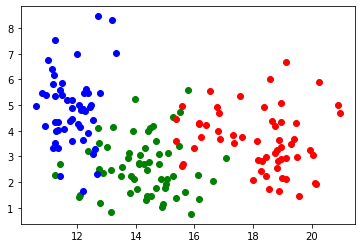

In [6]:
# plotting the Type A as a green dot
plt.plot(trainx[trainy==0,0], trainx[trainy==0,1], marker='o', ls='None', c='g')
# plotting Type B as a red dot
plt.plot(trainx[trainy==1,0], trainx[trainy==1,1], marker='o', ls='None', c='r')
# plotting Type C as a blue dot
plt.plot(trainx[trainy==2,0], trainx[trainy==2,1], marker='o', ls='None', c='b')

## Step 2. Model training: implementing Gaussian Discriminant Analysis




###  Sufficient statistics
Since we have 3 classes, we need to estimate the parameters for 3 bivariate Gaussian distributions.  To reduce the number of parameters we need to estimate, we will assume the distributions have the same covariance matrix.  Thus we will estimate the covariance matrix based on the training data in all three classes.

Just as if we were doing these calculations by hand, we break the process down into managable pieces

We begin by defining a helper function that we can use to estimate the shared covariance matrix.  

In [11]:
# Input: a design matrix (rows correspond to examples, columns to features)
# Output: the estimated covariance matrix for the features

mu_0 = mean(trainx, 0)
mu_1 = mean(trainx, 1)
mu_2 = mean(trainx, 2)

def estimate_cov(x):
########## TO DO ##########

    def sample_cov(x, classNum, mu):
        
        total = 0
        size = x[trainy == classNum, 0].size
        
        for data in x[trainy == classNum, 0]:
            total = total + (data - mu[0])**2
        sigma_00 = total / size
        
        total = 0
        for data in x[trainy == classNum, 1]:
            total = total + (data - mu[1])**2
        sigma_11 = total / size
        
        total = 0
        for data in x[trainy == classNum, 0:2]:
            total = total + ((data[0] - mu[0]) * (data[1] - mu[1]))
        sigma_01 = total / size
        
        return [[sigma_00, sigma_01], [sigma_01, sigma_11]]
    
    cov0Frac = x[trainy == 0].size/x.size
    cov1Frac = x[trainy == 1].size/x.size
    cov2Frac = x[trainy == 2].size/x.size
    
    
    print(f'mu_0 = {mu_0}\nmu_1 = {mu_1}\nmu_2 = {mu_2}')
    
    cov_0 = sample_cov(x, 0, mu_0)
    cov_1 = sample_cov(x, 1, mu_1)
    cov_2 = sample_cov(x, 2, mu_2)
    
    arr0 = np.asarray(cov_0,dtype = np.float32)
    arr1 = np.asarray(cov_1,dtype = np.float32)
    arr2 = np.asarray(cov_2,dtype = np.float32)
    
    Sigma = ((cov0Frac*arr0) + (cov1Frac*arr1) + (cov2Frac*arr2))
    
    print(f'Shared covariance: {Sigma}')

    #could use this for scalar multiplication on array: newarr = np.asarray(mu_0,dtype = np.float32)
    
##########
    return Sigma

estimate_cov(trainx)

mu_0 = [14.237833333333334, 2.617086666666667]
mu_1 = [18.201929824561404, 3.615964912280701]
mu_2 = [11.82411764705882, 4.875960784313725]
Shared covariance: [[ 1.3504497  -0.05885309]
 [-0.05885309  1.4810106 ]]


array([[ 1.3504497 , -0.05885309],
       [-0.05885309,  1.4810106 ]], dtype=float32)


Before moving on, test your code to make sure it works correctly.  




### Write the rest of your code here

In [9]:
predict = []

read = list(map(float,input().split()))

for i in range(0, len(read), 2):
    predict.append([read[i],read[i+1]])
    
predict

18.72 5.324 13.37 4.67 10.83 5.182 12.76 2.828 14.28 6.685 10.82 4.853 15.38 1.999 13.07 5.304 21.18 5.78 17.63 4.076 18.98 3.691 16.2 2.823 14.11 2.688 16.44 1.969 19.18 3.357 12.8 4.873 14.01 2.217 11.87 3.597 19.15 3.084 14.99 2.958 11.27 4.309


[[18.72, 5.324],
 [13.37, 4.67],
 [10.83, 5.182],
 [12.76, 2.828],
 [14.28, 6.685],
 [10.82, 4.853],
 [15.38, 1.999],
 [13.07, 5.304],
 [21.18, 5.78],
 [17.63, 4.076],
 [18.98, 3.691],
 [16.2, 2.823],
 [14.11, 2.688],
 [16.44, 1.969],
 [19.18, 3.357],
 [12.8, 4.873],
 [14.01, 2.217],
 [11.87, 3.597],
 [19.15, 3.084],
 [14.99, 2.958],
 [11.27, 4.309]]

In [12]:
from numpy.linalg import inv
import pandas as pd

def mean(x, classNum):
    
    count_0,count_1 = 0,0
    
    for data in x[trainy == classNum, 0:2]:
        count_0 = count_0 + data[0]
        count_1 = count_1 + data[1] 
    mu = [count_0 / x[trainy == classNum, 0].size, count_1 / x[trainy == classNum, 1].size]
    
    return mu

def prob(data, mu, sigma):
    
    #same covariance lets us omit it from likelihood calculations
    #log p = -1/2(x - mu)^T * sigma * (x - mu)
    
    sig_inv = inv(sigma)
    vec_1 = np.array([[data[0] - mu[0], data[1] - mu[1]]]) #vec_1 is transpose
    vec_2 = (np.array([[data[0] - mu[0], data[1] - mu[1]]])).transpose()
    return (-.5 * (np.dot(np.dot(vec_1,sig_inv), vec_2)))
    
            
data = predict

df = pd.DataFrame(data)
df.columns = ['area','asymm']
sigma = estimate_cov(trainx)

prob0 = []
prob1 = []
prob2 = []
arr = []
    
for i in range(len(data)):
    prob0 = prob(data[i],mu_0,sigma)[0][0]    
    prob1 = prob(data[i],mu_1,sigma)[0][0]  
    prob2 = prob(data[i],mu_2,sigma)[0][0] 
   # df['prob0'] = prob0
   # df['prob1'] = prob1
   # df['prob2'] = prob2

    print(prob0,prob1,prob2)
    
    if (prob0 > prob1) and (prob0 > prob2): #class0
        #df['Pred_Class'] = 0
        arr.append(0)
    
    elif (prob1 > prob0) and (prob1 > prob2): #class1
        #df['Pred_Class'] = 1
        arr.append(1)
        
    elif (prob2 > prob0) and (prob2 > prob1): #class2
        #df['Pred_Class'] = 2
        arr.append(2)
df['Prediction'] = arr
df

mu_0 = [14.237833333333334, 2.617086666666667]
mu_1 = [18.201929824561404, 3.615964912280701]
mu_2 = [11.82411764705882, 4.875960784313725]
Shared covariance: [[ 1.3504497  -0.05885309]
 [-0.05885309  1.4810106 ]]
-10.286809876042678 -1.1122680840291213 -17.79593568103928
-1.6521121039274722 -8.88495766605831 -0.8912945264994474
-6.274503545191964 -20.64521405143017 -0.3892458532187201
-0.8158756214003092 -11.320119991956364 -1.6867855471381137
-5.6021059992927915 -8.53547617477072 -3.474705458487023
-5.798042878135414 -20.45917775760249 -0.3748079370717931
-0.5922323767940735 -3.972233056492411 -7.187271712348263
-2.8549218680193227 -10.476314640816616 -0.6533856100245274
-21.90505616349514 -5.063125301407874 -32.99060717977704
-5.1334460734456275 -0.18513618097906442 -12.581555154142809
-8.88076585392168 -0.22815896681277684 -19.21692067072349
-1.4542097386651307 -1.7458691608034052 -8.262474054680863
-0.007494295515958364 -6.61328467632125 -3.4095532231690706
-1.8986190261233298 -2.

,area,asymm,Prediction
0,18.72,5.324,1
1,13.37,4.670,2
2,10.83,5.182,2
3,12.76,2.828,0
4,14.28,6.685,2
5,10.82,4.853,2
6,15.38,1.999,0
7,13.07,5.304,2
8,21.18,5.780,1
9,17.63,4.076,1


[[18.72   5.324]
 [13.37   4.67 ]
 [10.83   5.182]
 [12.76   2.828]
 [14.28   6.685]
 [10.82   4.853]
 [15.38   1.999]
 [13.07   5.304]
 [21.18   5.78 ]
 [17.63   4.076]
 [18.98   3.691]
 [16.2    2.823]
 [14.11   2.688]
 [16.44   1.969]
 [19.18   3.357]
 [12.8    4.873]
 [14.01   2.217]
 [11.87   3.597]
 [19.15   3.084]
 [14.99   2.958]
 [11.27   4.309]]
[1 2 2 0 2 2 0 2 1 1 1 0 0 0 1 2 0 2 1 0 2]


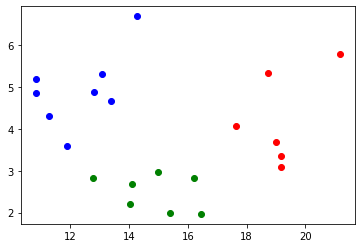

In [144]:
#plotting our predicted datset
xdata = np.array(data)
yarr = np.array(arr)
# plotting the Type A as a green dot
plt.plot(xdata[yarr==0,0], xdata[yarr==0,1], marker='o', ls='None', c='g')
# plotting Type B as a red dot
plt.plot(xdata[yarr==1,0], xdata[yarr==1,1], marker='o', ls='None', c='r')
# plotting Type C as a blue dot
plt.plot(xdata[yarr==2,0], xdata[yarr==2,1], marker='o', ls='None', c='b')